# CAO Points Notebook

***

Import all the necessary packages

In [1]:
# Package for HTTP requests
import requests as rq

# Regular experssions package
import re

# Import Pandas package
import pandas as pd

# Dates and time
import datetime as dt

# For comparing sequences (string for example)
import difflib

# For downloading files form the web
import urllib.request as urlrq

# For scatter plots
from pandas.plotting import scatter_matrix

# For numpy
import numpy as np

# For plotting
from matplotlib import pyplot as plt
import seaborn as sns

#### Create a now_string

This variable will be used to store the current date and time and used when saving the original data files with a timestamp

In [2]:
# get the current date and time
now = dt.datetime.now()

now_string = now.strftime('%Y%m%d_%H%M%S')

## 1. Read and prepare the 2019 points

****

### 1.1 Read the 2019 points


1. Points for 2019 year downloaded from http://www.cao.ie/index.php?page=points&p=2019 in .pdf file format
2. PDF file opened using Adobe Acrobat DC
3. Exported to .xlsx file format using Acrobat DC 'Export to' option
4. Pandas DataFrame created from saved .xlsx file

#### Read Level 8 courses

In [3]:
# Read the level 8 courses from the exported Excel file
df19 = pd.read_excel('data\cao2019_20211129_180145.xlsx', skiprows=10, dtype=str)

In [4]:
#Check the head of the dataframe
df19.head()

,Course Code,Unnamed: 1,INSTITUTION and COURSE,Unnamed: 3,EOS,Mid
0,NaN,NaN,Athlone Institute of Technology,NaN,NaN,NaN
1,AL801,NaN,Software Design with Virtual Reality and Gaming,NaN,304,328
2,AL802,NaN,Software Design with Cloud Computing,NaN,301,306
3,AL803,NaN,Software Design with Mobile Apps and Connected...,NaN,309,337
4,AL805,NaN,Network Management and Cloud Infrastructure,NaN,329,442


In [5]:
# Add 'Course Level' column and fill it with '8' 
df19['Course Level'] = '8'
df19.head()

,Course Code,Unnamed: 1,INSTITUTION and COURSE,Unnamed: 3,EOS,Mid,Course Level
0,NaN,NaN,Athlone Institute of Technology,NaN,NaN,NaN,8
1,AL801,NaN,Software Design with Virtual Reality and Gaming,NaN,304,328,8
2,AL802,NaN,Software Design with Cloud Computing,NaN,301,306,8
3,AL803,NaN,Software Design with Mobile Apps and Connected...,NaN,309,337,8
4,AL805,NaN,Network Management and Cloud Infrastructure,NaN,329,442,8


#### Read Level 6/7 courses

In [6]:
# Read the level 6/7 courses from the exported Excel file
l67 = pd.read_excel('data\cao2019_20211216_l67.xlsx', skiprows=8, dtype=str)

In [7]:
#Check the head of the dataframel
l67.head()

,Course Code,INSTITUTION and COURSE,EOS,Mid
0,NaN,Athlone Institute of Technology,NaN,NaN
1,AL600,Software Design,205,306
2,AL601,Computer Engineering,196,272
3,AL602,Mechanical Engineering,258,424
4,AL604,Civil Engineering,252,360


In [8]:
# Add 'Course Level' column and fill it with '6/7' - it is not highlighted explicitly which courses are Level 6 and which 7
l67['Course Level'] = '6/7'
l67.head()

,Course Code,INSTITUTION and COURSE,EOS,Mid,Course Level
0,NaN,Athlone Institute of Technology,NaN,NaN,6/7
1,AL600,Software Design,205,306,6/7
2,AL601,Computer Engineering,196,272,6/7
3,AL602,Mechanical Engineering,258,424,6/7
4,AL604,Civil Engineering,252,360,6/7


### 1.2 Clean the data

In [9]:
# List columns in imported dataframe
df19.columns

Index(['Course Code', 'Unnamed: 1', 'INSTITUTION and COURSE', 'Unnamed: 3',
       'EOS', 'Mid', 'Course Level'],
      dtype='object')

In [10]:
# Drop the columns that hold no data.
df19 = df19.drop(['Unnamed: 1', 'Unnamed: 3'], axis=1)

In [11]:
#Check the head of the dataframe after removing Unnamed columns:
df19.head()

,Course Code,INSTITUTION and COURSE,EOS,Mid,Course Level
0,NaN,Athlone Institute of Technology,NaN,NaN,8
1,AL801,Software Design with Virtual Reality and Gaming,304,328,8
2,AL802,Software Design with Cloud Computing,301,306,8
3,AL803,Software Design with Mobile Apps and Connected...,309,337,8
4,AL805,Network Management and Cloud Infrastructure,329,442,8


In [12]:
#Check the tail of the dataframe to make sure all the courses were imported:
df19.tail()

,Course Code,INSTITUTION and COURSE,EOS,Mid,Course Level
960,WD200,Arts (options),221,296,8
961,WD210,Software Systems Development,271,329,8
962,WD211,Creative Computing,275,322,8
963,WD212,Recreation and Sport Management,274,311,8
964,WD230,Mechanical and Manufacturing Engineering,273,348,8


#### Add Level 6/7 courses to df19

In [13]:
#Append DataFrame l67 to df19 and check the last 5 rows of the resulting DataFrame
df19 = df19.append(l67, ignore_index=True)
df19.tail()

,Course Code,INSTITUTION and COURSE,EOS,Mid,Course Level
1446,WD188,Applied Health Care,206,339,6/7
1447,WD205,Molecular Biology with Biopharmaceutical Science,208,441,6/7
1448,WD206,Electronic Engineering,191,322,6/7
1449,WD207,Mechanical Engineering,179,330,6/7
1450,WD208,Manufacturing Engineering,195,330,6/7


#### Create a list of HEI from 2019 dataset

In [14]:
# As the HEI list from 2020 data is not complete, I will create a list of HEI from 2019 data points
# 2019 dataset has a row with HEI description at the top of the list of courses in this institute
# I'll create a 'Code' column by coping the value of 'Course Code' from the next row
# As per https://stackoverflow.com/questions/30673209/pandas-compare-next-row

df19['Code'] = df19['Course Code'].shift(-1)
df19

,Course Code,INSTITUTION and COURSE,EOS,Mid,Course Level,Code
0,NaN,Athlone Institute of Technology,NaN,NaN,8,AL801
1,AL801,Software Design with Virtual Reality and Gaming,304,328,8,AL802
2,AL802,Software Design with Cloud Computing,301,306,8,AL803
3,AL803,Software Design with Mobile Apps and Connected...,309,337,8,AL805
4,AL805,Network Management and Cloud Infrastructure,329,442,8,AL810
...,...,...,...,...,...,...
1446,WD188,Applied Health Care,206,339,6/7,WD205
1447,WD205,Molecular Biology with Biopharmaceutical Science,208,441,6/7,WD206
1448,WD206,Electronic Engineering,191,322,6/7,WD207
1449,WD207,Mechanical Engineering,179,330,6/7,WD208


In [15]:
# Keep only two first letters in the 'Code' column
df19['Code'] = df19['Code'].str[0:2]
df19.head()

,Course Code,INSTITUTION and COURSE,EOS,Mid,Course Level,Code
0,NaN,Athlone Institute of Technology,NaN,NaN,8,AL
1,AL801,Software Design with Virtual Reality and Gaming,304,328,8,AL
2,AL802,Software Design with Cloud Computing,301,306,8,AL
3,AL803,Software Design with Mobile Apps and Connected...,309,337,8,AL
4,AL805,Network Management and Cloud Infrastructure,329,442,8,AL


In [16]:
#institute names are stored in the rows that don't have any values in the 'Course code' column
hei19 = df19[df19['Course Code'].isna()][['INSTITUTION and COURSE', 'Code']]
hei19.columns=['HEI', 'CODE']
hei19.head()

,HEI,CODE
0,Athlone Institute of Technology,AL
28,"Institute of Technology, Carlow",CW
62,"Carlow College, St. Patrick`s",PC
66,Cork Institute of Technology,CR
110,University College Cork (NUI),CK


In [17]:
# DataFrames for Level 8 and Level 6/7 were joined, there must be duplicates in the HEI list.
# Removing the duplicates by Code, as there might be slight typos in the HEI titles

hei19.drop_duplicates(subset='CODE', inplace=True, ignore_index=True)
hei19.tail()

,HEI,CODE
33,"Institute of Technology, Tralee",TL
34,Waterford Institute of Technology,WD
35,Dorset College,DS
36,St Nicholas Montessori College Ireland,NM
37,Galway Business School,GB


#### Remove the rows with the HEI title from the courses DataFrame

In [18]:
# Column 'Code' is not needed anymore in the df19 table, removing it
df19 = df19.drop('Code',  axis=1)

In [19]:
#Remove the rows with HEI description:
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html
print("Shape of the dataFrame with HEI names: {}".format(df19.shape))
df19 = df19.dropna(axis=0, subset=['Course Code'])
print("Shape of the dataFrame without HEI names: {}".format(df19.shape))

Shape of the dataFrame with HEI names: (1451, 5)
Shape of the dataFrame without HEI names: (1391, 5)


In [20]:
# Check that all the rows without values defined in 'Course Code' column are removed
df19[df19['Course Code'].isna()]

,Course Code,INSTITUTION and COURSE,EOS,Mid,Course Level


### 1.3 Format the data 

In [21]:
# 1. Filter df19 dataframe to include only EOS points that start with '#'
# 2. Once it's filtered, iterate through it to remove the '#' from the poitns value
# 3. Add the '#' to the 'Test/Interview #' column

# As per https://stackoverflow.com/questions/62397170/python-pandas-how-to-select-rows-where-objects-start-with-letters-pl
# List all the courses that start with '#'

df19['2019 Interview'] = 0

for index, row in df19[df19['EOS'].str.startswith('#', na=False)].iterrows():
    points = df19.loc[index, 'EOS'][1:]
    
    df19.loc[index, 'EOS'] = points
    df19.loc[index, '2019 Interview'] = 1

In [22]:
# Check that a new column 'Test/Interview #' was created and populated correctly and that # was removed from the points value
df19[df19['2019 Interview']==1].head(5)

,Course Code,INSTITUTION and COURSE,EOS,Mid,Course Level,2019 Interview
24,AL861,Animation and Illustration (portfolio),615,899,8,1
25,AL863,Graphic and Digital Design (portfolio),703,898,8,1
31,CW038,"Art (portfolio, Wexford)",700,700,8,1
58,CW858,"Sports Management and Coaching (options, portf...",700,700,8,1
74,CR121,Music at CIT Cork School of Music,633,1052,8,1


In [23]:
# Display 5 top courses that have '*' at the end of the points 
df19[df19['EOS'].str.endswith('*', na=False)].head(5)

,Course Code,INSTITUTION and COURSE,EOS,Mid,Course Level,2019 Interview
129,CK201,Commerce,465*,489,8,0
163,CK704,Occupational Therapy,532*,554,8,0
166,CK707,Medical and Health Sciences,510*,543,8,0
172,CK791,Medicine - Graduate Entry (GAMSAT required),58*,59,8,1
179,CM001,Education - Primary Teaching,452*,462,8,0


In [24]:
# 1. Filter df19 dataframe to include only EOS points that have '*' at the end
# 2. Once it's filtered, iterate through it to remove the '*' from the poitns value
# 3. Add the '*' to the 'R1 Random *' column

df19['2019 R1 Random'] = 0

for index, row in df19[df19['EOS'].str.endswith('*', na=False)].iterrows():
    points = df19.loc[index, 'EOS'][:-1]
    
    df19.loc[index, 'EOS'] = points
    df19.loc[index, '2019 R1 Random'] = 1

In [25]:
# Check that a new column 'R1 Random *' was created and populated correctly and that * was removed from the points value
df19[df19['2019 R1 Random']==1].head(5)

,Course Code,INSTITUTION and COURSE,EOS,Mid,Course Level,2019 Interview,2019 R1 Random
129,CK201,Commerce,465,489,8,0,1
163,CK704,Occupational Therapy,532,554,8,0,1
166,CK707,Medical and Health Sciences,510,543,8,0,1
172,CK791,Medicine - Graduate Entry (GAMSAT required),58,59,8,1,1
179,CM001,Education - Primary Teaching,452,462,8,0,1


In [26]:
# Display 5 top courses that have '*' at the end of the 'Mid' column values
df19[df19['Mid'].str.endswith('*', na=False)]

,Course Code,INSTITUTION and COURSE,EOS,Mid,Course Level,2019 Interview,2019 R1 Random


#### Rename the column to match the general template

In [27]:
# Rename the columns in the df19 dataFrame
df19.columns=['COURSE CODE','COURSE TITLE', 'R1 2019', 'R2 2019', 'Course Level', '2019 Interview', '2019 R1 Random']
df19.head()

,COURSE CODE,COURSE TITLE,R1 2019,R2 2019,Course Level,2019 Interview,2019 R1 Random
1,AL801,Software Design with Virtual Reality and Gaming,304,328,8,0,0
2,AL802,Software Design with Cloud Computing,301,306,8,0,0
3,AL803,Software Design with Mobile Apps and Connected...,309,337,8,0,0
4,AL805,Network Management and Cloud Infrastructure,329,442,8,0,0
5,AL810,Quantity Surveying,307,349,8,0,0


In [28]:
# Check if there are duplicates in the 'COURSE CODE' column
# as per https://stackoverflow.com/questions/50242968/check-for-duplicate-values-in-pandas-dataframe-column

df19['COURSE CODE'].is_unique

True

In [29]:
# 'COURSE CODE' column has no duplicates, set it as an Index
df19.set_index('COURSE CODE', inplace=True)
df19.head()

,COURSE TITLE,R1 2019,R2 2019,Course Level,2019 Interview,2019 R1 Random
COURSE CODE,,,,,,
AL801,Software Design with Virtual Reality and Gaming,304,328,8,0,0
AL802,Software Design with Cloud Computing,301,306,8,0,0
AL803,Software Design with Mobile Apps and Connected...,309,337,8,0,0
AL805,Network Management and Cloud Infrastructure,329,442,8,0,0
AL810,Quantity Surveying,307,349,8,0,0


In [30]:
# Currently columns 'R1 2019' and 'R2 2019' are stored as String.
# Converting both to integer. Using errors='coerce' will turn all non-numeric values into NaN
# As per https://pandas.pydata.org/docs/reference/api/pandas.to_numeric.html
# and https://stackoverflow.com/questions/15891038/change-column-type-in-pandas

df19['R1 2019'] = pd.to_numeric(df19['R1 2019'], errors='coerce')
df19['R2 2019'] = pd.to_numeric(df19['R2 2019'], errors='coerce')

In [31]:
df19.head()

,COURSE TITLE,R1 2019,R2 2019,Course Level,2019 Interview,2019 R1 Random
COURSE CODE,,,,,,
AL801,Software Design with Virtual Reality and Gaming,304.0,328.0,8,0,0
AL802,Software Design with Cloud Computing,301.0,306.0,8,0,0
AL803,Software Design with Mobile Apps and Connected...,309.0,337.0,8,0,0
AL805,Network Management and Cloud Infrastructure,329.0,442.0,8,0,0
AL810,Quantity Surveying,307.0,349.0,8,0,0


#### Export the DataFrame to csv file

In [32]:
# Create a filepath with a current timestamp for the pandas data
filepath = 'data/cao2019_pandas' + now_string + '.csv'

# save the pandas dataframe as a csv file
df19.to_csv(filepath, index=False)

## 2. Read and prepare the 2020 points
****

### 2.1 Read the 2020 points from the CAO website

In [33]:
# Read the file directly from the CAO website
url = 'http://www2.cao.ie/points/CAOPointsCharts2020.xlsx'
df20 = pd.read_excel(url, skiprows=10)

##### Download the original 2020 file to the disk

In [34]:
# Create a filepath with a current timestamp for the original data
filepath = 'data/cao2020_' + now_string + '.xlsx'

In [35]:
urlrq.urlretrieve(url, filepath)

('data/cao2020_20211222_105035.xlsx',
 <http.client.HTTPMessage at 0x1d8c690b130>)

In [36]:
# Check the shape of the dataframe
df20.shape

(1464, 23)

### 2.2 Clean the data

In [37]:
# Show 5 first rows of the dataframe
df20.head()

,CATEGORY (i.e.ISCED description),COURSE TITLE,COURSE CODE2,R1 POINTS,R1 Random *,R2 POINTS,R2 Random*,EOS,EOS Random *,EOS Mid-point,...,avp,v,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
0,Business and administration,International Business,AC120,209,NaN,NaN,NaN,209,NaN,280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Humanities (except languages),Liberal Arts,AC137,252,NaN,NaN,NaN,252,NaN,270,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arts,"First Year Art & Design (Common Entry,portfolio)",AD101,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Arts,Graphic Design and Moving Image Design (portfo...,AD102,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arts,Textile & Surface Design and Jewellery & Objec...,AD103,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Columns named Column1-Column8 serve no purpose, they need to be removed. First I will list all the columns in the dataframe and then use it as a reference for removing them:

In [38]:
# List the columns in the datafarme
df20.columns

Index(['CATEGORY (i.e.ISCED description)', 'COURSE TITLE', 'COURSE CODE2',
       'R1 POINTS', 'R1 Random *', 'R2 POINTS', 'R2 Random*', 'EOS',
       'EOS Random *', 'EOS Mid-point', 'LEVEL', 'HEI', 'Test/Interview #',
       'avp', 'v', 'Column1', 'Column2', 'Column3', 'Column4', 'Column5',
       'Column6', 'Column7', 'Column8'],
      dtype='object')

In [39]:
# There are 23 columns in the dataframe, we need to remove 8, so we'll remove the columns from 15 to 23:
df20 = df20.drop(df20.columns[15:23], axis=1)

In [40]:
# Check the head of the dataframe to make sure correct columns were removed
df20.head()

,CATEGORY (i.e.ISCED description),COURSE TITLE,COURSE CODE2,R1 POINTS,R1 Random *,R2 POINTS,R2 Random*,EOS,EOS Random *,EOS Mid-point,LEVEL,HEI,Test/Interview #,avp,v
0,Business and administration,International Business,AC120,209,NaN,NaN,NaN,209,NaN,280,8,American College,NaN,NaN,NaN
1,Humanities (except languages),Liberal Arts,AC137,252,NaN,NaN,NaN,252,NaN,270,8,American College,NaN,NaN,NaN
2,Arts,"First Year Art & Design (Common Entry,portfolio)",AD101,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,8,National College of Art and Design,#,NaN,NaN
3,Arts,Graphic Design and Moving Image Design (portfo...,AD102,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,8,National College of Art and Design,#,NaN,NaN
4,Arts,Textile & Surface Design and Jewellery & Objec...,AD103,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,8,National College of Art and Design,#,NaN,NaN


In [41]:
# Check the end of the dataframe, to make sure all the rows were loaded
df20.tail()

,CATEGORY (i.e.ISCED description),COURSE TITLE,COURSE CODE2,R1 POINTS,R1 Random *,R2 POINTS,R2 Random*,EOS,EOS Random *,EOS Mid-point,LEVEL,HEI,Test/Interview #,avp,v
1459,Manufacturing and processing,Manufacturing Engineering,WD208,188,NaN,NaN,NaN,188,NaN,339,7,Waterford Institute of Technology,NaN,NaN,NaN
1460,Information and Communication Technologies (ICTs),Software Systems Development,WD210,279,NaN,NaN,NaN,279,NaN,337,8,Waterford Institute of Technology,NaN,NaN,NaN
1461,Information and Communication Technologies (ICTs),Creative Computing,WD211,271,NaN,NaN,NaN,271,NaN,318,8,Waterford Institute of Technology,NaN,NaN,NaN
1462,Personal services,Recreation and Sport Management,WD212,270,NaN,NaN,NaN,270,NaN,349,8,Waterford Institute of Technology,NaN,NaN,NaN
1463,Engineering and engineering trades,Mechanical and Manufacturing Engineering,WD230,253,NaN,NaN,NaN,253,NaN,369,8,Waterford Institute of Technology,NaN,NaN,NaN


In [42]:
# Spot check, make sure that Excels row 765 was imported correctly. 
# Recalculate the index by substracting 10 skipped rows and allow for the fact that panda numbers rows from 0 and Excel from 1 plus allow for the first row being used as header
df20.iloc[765-12]

CATEGORY (i.e.ISCED description)          Engineering and engineering trades
COURSE TITLE                        Road Transport Technology and Management
COURSE CODE2                                                           LC286
R1 POINTS                                                                264
R1 Random *                                                              NaN
R2 POINTS                                                                NaN
R2 Random*                                                               NaN
EOS                                                                      264
EOS Random *                                                             NaN
EOS Mid-point                                                            360
LEVEL                                                                      7
HEI                                         Limerick Institute of Technology
Test/Interview #                                                         NaN

### 2.3 Format the data

In [43]:
# 1. Filter df20 dataframe to include only EOS points that start with '#'
# 2. Once it's filtered, iterate through it to remove the '#' from the poitns value
# 3. Add the '#' to the 'Test/Interview #' column

# As per https://stackoverflow.com/questions/62397170/python-pandas-how-to-select-rows-where-objects-start-with-letters-pl
# List all the courses that start with '#'

for index, row in df20[df20['R1 POINTS'].str.startswith('#', na=False)].iterrows():
    points = df20.loc[index, 'R1 POINTS'][1:]
    
    df20.loc[index, 'R1 POINTS'] = points

df20.head(5)

,CATEGORY (i.e.ISCED description),COURSE TITLE,COURSE CODE2,R1 POINTS,R1 Random *,R2 POINTS,R2 Random*,EOS,EOS Random *,EOS Mid-point,LEVEL,HEI,Test/Interview #,avp,v
0,Business and administration,International Business,AC120,209,NaN,NaN,NaN,209,NaN,280,8,American College,NaN,NaN,NaN
1,Humanities (except languages),Liberal Arts,AC137,252,NaN,NaN,NaN,252,NaN,270,8,American College,NaN,NaN,NaN
2,Arts,"First Year Art & Design (Common Entry,portfolio)",AD101,+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,8,National College of Art and Design,#,NaN,NaN
3,Arts,Graphic Design and Moving Image Design (portfo...,AD102,+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,8,National College of Art and Design,#,NaN,NaN
4,Arts,Textile & Surface Design and Jewellery & Objec...,AD103,+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,8,National College of Art and Design,#,NaN,NaN


In [44]:
# Some of the rows that
df20 = df20.replace('#',1)

In [45]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html
df20 = df20.replace('*',1)

In [46]:
df20[df20['R1 Random *']==1].head(5)

,CATEGORY (i.e.ISCED description),COURSE TITLE,COURSE CODE2,R1 POINTS,R1 Random *,R2 POINTS,R2 Random*,EOS,EOS Random *,EOS Mid-point,LEVEL,HEI,Test/Interview #,avp,v
53,Health,Psychiatric Nursing,AL832,387,1.0,384,NaN,384,NaN,399,8,Athlone Institute of Technology,NaN,NaN,NaN
74,Education,"Education, Home Economics and Religious Ed - w...",AS002,441,1.0,434,1.0,434,1.0,466,8,St. Angela`s College,NaN,NaN,NaN
75,Education,"Education, Home Economics and Irish - with con...",AS003,440,1.0,440,NaN,440,NaN,484,8,St. Angela`s College,NaN,NaN,NaN
78,Health,General Nursing,AS110,419,1.0,NaN,NaN,419,1.0,431,8,St. Angela`s College,NaN,NaN,NaN
79,Health,Intellectual Disability Nursing,AS130,336,1.0,328,NaN,317,NaN,339,8,St. Angela`s College,NaN,NaN,NaN


In [47]:
# Change NaN values to 0

# as per https://stackoverflow.com/questions/13295735/how-to-replace-nan-values-by-zeroes-in-a-column-of-a-pandas-dataframe
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html

df20[['R1 Random *','R2 Random*', 'Test/Interview #']] = df20[['R1 Random *','R2 Random*', 'Test/Interview #']].fillna(value=0)
df20

,CATEGORY (i.e.ISCED description),COURSE TITLE,COURSE CODE2,R1 POINTS,R1 Random *,R2 POINTS,R2 Random*,EOS,EOS Random *,EOS Mid-point,LEVEL,HEI,Test/Interview #,avp,v
0,Business and administration,International Business,AC120,209,0.0,NaN,0.0,209,NaN,280,8,American College,0.0,NaN,NaN
1,Humanities (except languages),Liberal Arts,AC137,252,0.0,NaN,0.0,252,NaN,270,8,American College,0.0,NaN,NaN
2,Arts,"First Year Art & Design (Common Entry,portfolio)",AD101,+matric,0.0,NaN,0.0,#+matric,NaN,#+matric,8,National College of Art and Design,1.0,NaN,NaN
3,Arts,Graphic Design and Moving Image Design (portfo...,AD102,+matric,0.0,NaN,0.0,#+matric,NaN,#+matric,8,National College of Art and Design,1.0,NaN,NaN
4,Arts,Textile & Surface Design and Jewellery & Objec...,AD103,+matric,0.0,NaN,0.0,#+matric,NaN,#+matric,8,National College of Art and Design,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,Manufacturing and processing,Manufacturing Engineering,WD208,188,0.0,NaN,0.0,188,NaN,339,7,Waterford Institute of Technology,0.0,NaN,NaN
1460,Information and Communication Technologies (ICTs),Software Systems Development,WD210,279,0.0,NaN,0.0,279,NaN,337,8,Waterford Institute of Technology,0.0,NaN,NaN
1461,Information and Communication Technologies (ICTs),Creative Computing,WD211,271,0.0,NaN,0.0,271,NaN,318,8,Waterford Institute of Technology,0.0,NaN,NaN
1462,Personal services,Recreation and Sport Management,WD212,270,0.0,NaN,0.0,270,NaN,349,8,Waterford Institute of Technology,0.0,NaN,NaN


#### Rename the columns in the df20 dataframe to match the general template

In [48]:
# Rename the columns in the df20 DataFrame
df20.columns=['CATEGORY', 'COURSE TITLE', 'COURSE CODE', 'R1 2020', '2020 R1 Random', 'R2 2020', '2020 R2 Random', 
              'EOS', 'EOS Random *', 'EOS Mid-point', 'Course Level', 'HEI', '2020 Interview', 'avp', 'v']

In [49]:
df20.head()

,CATEGORY,COURSE TITLE,COURSE CODE,R1 2020,2020 R1 Random,R2 2020,2020 R2 Random,EOS,EOS Random *,EOS Mid-point,Course Level,HEI,2020 Interview,avp,v
0,Business and administration,International Business,AC120,209,0.0,NaN,0.0,209,NaN,280,8,American College,0.0,NaN,NaN
1,Humanities (except languages),Liberal Arts,AC137,252,0.0,NaN,0.0,252,NaN,270,8,American College,0.0,NaN,NaN
2,Arts,"First Year Art & Design (Common Entry,portfolio)",AD101,+matric,0.0,NaN,0.0,#+matric,NaN,#+matric,8,National College of Art and Design,1.0,NaN,NaN
3,Arts,Graphic Design and Moving Image Design (portfo...,AD102,+matric,0.0,NaN,0.0,#+matric,NaN,#+matric,8,National College of Art and Design,1.0,NaN,NaN
4,Arts,Textile & Surface Design and Jewellery & Objec...,AD103,+matric,0.0,NaN,0.0,#+matric,NaN,#+matric,8,National College of Art and Design,1.0,NaN,NaN


In [50]:
# Check if 'COURSE CODE' column is unique
df20['COURSE CODE'].is_unique

True

In [51]:
# Since the 'COURSE CODE' has no duplicates, I'll set the column 'COURSE CODE' as an Index

df20.set_index('COURSE CODE', inplace=True)
df20.head()

,CATEGORY,COURSE TITLE,R1 2020,2020 R1 Random,R2 2020,2020 R2 Random,EOS,EOS Random *,EOS Mid-point,Course Level,HEI,2020 Interview,avp,v
COURSE CODE,,,,,,,,,,,,,,
AC120,Business and administration,International Business,209,0.0,NaN,0.0,209,NaN,280,8,American College,0.0,NaN,NaN
AC137,Humanities (except languages),Liberal Arts,252,0.0,NaN,0.0,252,NaN,270,8,American College,0.0,NaN,NaN
AD101,Arts,"First Year Art & Design (Common Entry,portfolio)",+matric,0.0,NaN,0.0,#+matric,NaN,#+matric,8,National College of Art and Design,1.0,NaN,NaN
AD102,Arts,Graphic Design and Moving Image Design (portfo...,+matric,0.0,NaN,0.0,#+matric,NaN,#+matric,8,National College of Art and Design,1.0,NaN,NaN
AD103,Arts,Textile & Surface Design and Jewellery & Objec...,+matric,0.0,NaN,0.0,#+matric,NaN,#+matric,8,National College of Art and Design,1.0,NaN,NaN


In [52]:
# Currently columns 'R1 2020' and 'R2 2020' are stored as String.
# Converting both to integer. Using errors='coerce' will turn all non-numeric values into NaN
# As per https://pandas.pydata.org/docs/reference/api/pandas.to_numeric.html
# and https://stackoverflow.com/questions/15891038/change-column-type-in-pandas

df20['R1 2020'] = pd.to_numeric(df20['R1 2020'], errors='coerce')
df20['R2 2020'] = pd.to_numeric(df20['R2 2020'], errors='coerce')
df20.head()

,CATEGORY,COURSE TITLE,R1 2020,2020 R1 Random,R2 2020,2020 R2 Random,EOS,EOS Random *,EOS Mid-point,Course Level,HEI,2020 Interview,avp,v
COURSE CODE,,,,,,,,,,,,,,
AC120,Business and administration,International Business,209.0,0.0,NaN,0.0,209,NaN,280,8,American College,0.0,NaN,NaN
AC137,Humanities (except languages),Liberal Arts,252.0,0.0,NaN,0.0,252,NaN,270,8,American College,0.0,NaN,NaN
AD101,Arts,"First Year Art & Design (Common Entry,portfolio)",NaN,0.0,NaN,0.0,#+matric,NaN,#+matric,8,National College of Art and Design,1.0,NaN,NaN
AD102,Arts,Graphic Design and Moving Image Design (portfo...,NaN,0.0,NaN,0.0,#+matric,NaN,#+matric,8,National College of Art and Design,1.0,NaN,NaN
AD103,Arts,Textile & Surface Design and Jewellery & Objec...,NaN,0.0,NaN,0.0,#+matric,NaN,#+matric,8,National College of Art and Design,1.0,NaN,NaN


#### Export the dataframe to csv file

In [53]:
# Create a filepath with a current timestamp for the pandas data
filepath = 'data/cao2020_pandas' + now_string + '.csv'

In [54]:
# save the pandas dataframe as a csv file
df20.to_csv(filepath, index=False)

### 2.4 Create a dataframe that holds all the names of Higher Education Institutions and first 2 letter of their courses

In [55]:
df20['CODE']=df20.index.str[0:2]
df20.head()

,CATEGORY,COURSE TITLE,R1 2020,2020 R1 Random,R2 2020,2020 R2 Random,EOS,EOS Random *,EOS Mid-point,Course Level,HEI,2020 Interview,avp,v,CODE
COURSE CODE,,,,,,,,,,,,,,,
AC120,Business and administration,International Business,209.0,0.0,NaN,0.0,209,NaN,280,8,American College,0.0,NaN,NaN,AC
AC137,Humanities (except languages),Liberal Arts,252.0,0.0,NaN,0.0,252,NaN,270,8,American College,0.0,NaN,NaN,AC
AD101,Arts,"First Year Art & Design (Common Entry,portfolio)",NaN,0.0,NaN,0.0,#+matric,NaN,#+matric,8,National College of Art and Design,1.0,NaN,NaN,AD
AD102,Arts,Graphic Design and Moving Image Design (portfo...,NaN,0.0,NaN,0.0,#+matric,NaN,#+matric,8,National College of Art and Design,1.0,NaN,NaN,AD
AD103,Arts,Textile & Surface Design and Jewellery & Objec...,NaN,0.0,NaN,0.0,#+matric,NaN,#+matric,8,National College of Art and Design,1.0,NaN,NaN,AD


In [56]:
# Use only columns HEI and CODE to create a new hei DataFrame
hei = df20[['HEI', 'CODE']]
hei.head()

,HEI,CODE
COURSE CODE,,
AC120,American College,AC
AC137,American College,AC
AD101,National College of Art and Design,AD
AD102,National College of Art and Design,AD
AD103,National College of Art and Design,AD


In [57]:
hei = hei.drop_duplicates(ignore_index=True)
hei.tail()

,HEI,CODE
31,"Institute of Technology, Sligo",SG
32,"Institute of Technology, Tralee",TL
33,Trinity College Dublin,TR
34,Technological University Dublin,TU
35,Waterford Institute of Technology,WD


In [58]:
# check if 'CODE' column is unique:
hei['CODE'].is_unique

True

## 3. Read and prepare the 2021 points
****


### 3.1 Read the points from the CAO website

In [59]:
# URL of the page with the 2021 CAO points
url = 'http://www2.cao.ie/points/l8.php'

# Fetch the CAO points URL
resp = rq.get(url)

resp

<Response [200]>

#### Save the original html file

In [60]:
# Create a filepath with a current timestamp for the original data
filepath = 'data/cao2021_' + now_string + '.html'

In [61]:
# Server uses wron encoding, we need to fix it
orig_encoding = resp.encoding

# We need to use 'cp1252' endcoding
new_encoding = 'cp1252'

#change to cp1252
resp.encoding = new_encoding

In [62]:
# Save the original html file in csv format
with open(filepath, 'w') as f:
    f.write(resp.text)

### 3.2 Clean the data

In [63]:
# compile regular expression to find all the numbers in the String
points = re.compile('[0-9]+')

In [64]:
def extract_points(chunk):
    # Match all the numbers in the string
    pnt = points.search(chunk)

    # Find the difference between the starting string and the found numbers
    # In order to extract any special requirements like *, # etc
    # Solution found on:
    # https://stackoverflow.com/questions/17904097/python-difference-between-two-strings
    diff = [li.replace('+ ','') for li in difflib.ndiff(pnt.group(0), chunk) if li[0] != ' ']
    
    return pnt.group(0), ' '.join(diff)

In [65]:
# Define the function for splitting the lines

def split_dline(input_line):
    
    result = []
    
    # split the line by 3 or more spaces (2 spaces are not enough as there are 2 spaces in some of the courses descriptions)
    space_separated = re.split('   +', input_line)
    
    # The first string in the resulting list is the course code and title, in the format: 'AL801  Software Design for Virtual Reality and Gaming'
    code_title = space_separated[0]   
    
    # The code is first 5 characters 
    result.append(code_title[0:5])
            
    # The title starts at 7th location
    result.append(code_title[7:len(code_title)])
    
    result.append(space_separated[1])
    
    try:
        result.append(space_separated[2]) 
    except IndexError:
        result.append("")

    
    # Join code, title an the rest of the line into one coma separated line:
    result = ','.join(result)  + '\n'
    
    
    
    return result

In [66]:
# Compile the reqular expression for matching lines
#re_courses = re.compile(r'([A-Z]{2}[0-9]{3})  (.*)  ([0-9]{3}\*?)( [0-9]{3})? *')
re_all_courses = re.compile('[A-Z]{2}[0-9]{3}')

#### Export loaded data to csv file

In [67]:
# Create a path for csv file
filepath21 = 'data/cao2021_' + now_string + '.csv'

# loop through the lines of the sesponse content
no_lines = 0

# Open the csv file for writing
with open(filepath21, 'w') as f:
    
    # Add first line with column titles
    # Use the same column titles as in the 2020 Excel file
    f.write("COURSE CODE2,COURSE TITLE,R1 POINTS,R2 POINTS \n")
    
    for line in resp.iter_lines():
        
        dline = line.decode(new_encoding)
        
        # Check if line starts with two capital letters followed by three numbers: ('[A-Z]{2}[0-9]{3}')
        matched = re_all_courses.match(dline)
        if matched:    
            
            # write a slit line into the csv file
            f.write(split_dline(dline))
            
            # count number of matching lines
            no_lines = no_lines + 1

print("Number of courses found {}".format(no_lines))

Number of courses found 949


#### Load the saved csv file to pandas DataFrame

In [68]:
# Create a Pandas dataframe from the saved csv file

df21 = pd.read_csv(filepath21, encoding='cp1252')
df21.head(5)

,COURSE CODE2,COURSE TITLE,R1 POINTS,R2 POINTS
0,AL801,Software Design for Virtual Reality and Gaming,300,NaN
1,AL802,Software Design in Artificial Intelligence for...,313,NaN
2,AL803,Software Design for Mobile Apps and Connected ...,350,NaN
3,AL805,Computer Engineering for Network Infrastructure,321,NaN
4,AL810,Quantity Surveying,328,NaN


### 3.3 Format the 2021 data

In [69]:
print(df21.columns)
df21.head(5)

Index(['COURSE CODE2', 'COURSE TITLE', 'R1 POINTS', 'R2 POINTS '], dtype='object')


,COURSE CODE2,COURSE TITLE,R1 POINTS,R2 POINTS
0,AL801,Software Design for Virtual Reality and Gaming,300,NaN
1,AL802,Software Design in Artificial Intelligence for...,313,NaN
2,AL803,Software Design for Mobile Apps and Connected ...,350,NaN
3,AL805,Computer Engineering for Network Infrastructure,321,NaN
4,AL810,Quantity Surveying,328,NaN


In [70]:
df21.columns=['COURSE CODE', 'COURSE TITLE', 'R1 2021', 'R2 2021']

#### Create '2021 R1 Interview' and '2021 R2 Interview' columns

In [71]:
# 1. Filter df21 dataframe to include only R1 2021 points that start with '#'
# 2. Once it's filtered, iterate through it to remove the '#' from the poitns value
# 3. Add the '#' to the 'Test/Interview #' column

# As per https://stackoverflow.com/questions/62397170/python-pandas-how-to-select-rows-where-objects-start-with-letters-pl
# List all the courses that start with '#'

# Populate the '2021 Interview' column with default value of 0
df21['2021 R1 Interview'] = 0

for index, row in df21[df21['R1 2021'].str.startswith('#', na=False)].iterrows():
    points = df21.loc[index, 'R1 2021'][1:]
    
    df21.loc[index, 'R1 2021'] = points
    
    
    df21.loc[index, '2021 R1 Interview'] = 1 

In [72]:
# Check the first 5 rows where '2021 R1 Interview' column is 1
df21[df21['2021 R1 Interview']==1].head()

,COURSE CODE,COURSE TITLE,R1 2021,R2 2021,2021 R1 Interview
27,AL861,Animation and Illustration (portfolio),575,NaN,1
28,AL863,Graphic and Digital Design (portfolio),747,NaN,1
33,CW038,Art (portfolio),700,NaN,1
61,CW858,Sports Management and Coaching (options portf...,700,NaN,1
75,CR121,Music at CIT Cork School of Music,904,#904,1


In [73]:
# Create a '2021 R2 Interview' column using the same method as above

df21['2021 R2 Interview'] = 0

for index, row in df21[df21['R2 2021'].str.startswith('#', na=False)].iterrows():
    points = df21.loc[index, 'R2 2021'][1:]
    
    df21.loc[index, 'R2 2021'] = points
    
    
    df21.loc[index, '2021 R2 Interview'] = 1 

In [74]:
# Check the first 5 rows where '2021 R2 Interview' column is 1
df21[df21['2021 R2 Interview']==1].head()

,COURSE CODE,COURSE TITLE,R1 2021,R2 2021,2021 R1 Interview,2021 R2 Interview
75,CR121,Music at CIT Cork School of Music,904,904,1,1
109,CR700,Theatre and Drama Studies at CIT Cork School o...,609,609,1,1
162,CK701,Medicine (Undergraduate Entry - HPAT required),738,737*,1,1
174,CK791,Medicine - Graduate Entry (GAMSAT required),60*,60*,1,1
281,DL833,Photography and Visual Media,671,671,1,1


#### Add the '2021 R1 Random' and '2021 R2 Random' columns

In [75]:
# 1. Filter df21 dataframe to include only R1 2021 points that have '*' at the end
# 2. Once it's filtered, iterate through it to remove the '*' from the poitns value
# 3. Add the 1 to the '2021 R1 Random *' column

# Assign the default value of 0 to 2021 R1 Random
df21['2021 R1 Random'] = 0

for index, row in df21[df21['R1 2021'].str.endswith('*', na=False)].iterrows():
    points = df21.loc[index, 'R1 2021'][:-1]
    
    df21.loc[index, 'R1 2021'] = points
    # Chnage to 1 only if 'R1 2021' poits end with '*'
    df21.loc[index, '2021 R1 Random'] = 1

In [76]:
# Check the first 5 rows where '2021 R1 Random' column is 1
df21[df21['2021 R1 Random']==1].head()

,COURSE CODE,COURSE TITLE,R1 2021,R2 2021,2021 R1 Interview,2021 R2 Interview,2021 R1 Random
7,AL830,General Nursing,451,444,0,0,1
8,AL832,Mental Health Nursing,440,431,0,0,1
30,AL870,Applied Psychology,484,467*,0,0,1
84,CR320,Biomedical Science - Offered jointly by CIT an...,590,NaN,0,0,1
110,CR930,Home Economics and Business,518,NaN,0,0,1


In [77]:
# Create a '2021 R2 Random' column using the same method as above

df21['2021 R2 Random'] = 0

for index, row in df21[df21['R2 2021'].str.endswith('*', na=False)].iterrows():
    points = df21.loc[index, 'R2 2021'][:-1]
    
    df21.loc[index, 'R2 2021'] = points
    # Chnage to 1 only if 'R1 2021' poits end with '*'
    df21.loc[index, '2021 R2 Random'] = 1

In [78]:
# Check the first 5 rows where '2021 R2 Random' column is 1
df21[df21['2021 R2 Random']==1].head()

,COURSE CODE,COURSE TITLE,R1 2021,R2 2021,2021 R1 Interview,2021 R2 Interview,2021 R1 Random,2021 R2 Random
15,AL841,Athletic and Rehabilitation Therapy,477,476,0,0,0,1
30,AL870,Applied Psychology,484,467,0,0,1,1
114,CK105,Film and Screen Media - 3 years or 4 years (In...,421,420,0,0,0,1
125,CK120,Applied Psychology,544,543,0,0,0,1
130,CK125,Sports Studies and Physical Education,564,555,0,0,0,1


#### Fill all the NaN values in the 'R2 2021' column with 0

In [79]:
# df21['R2 2021'] = df21['R2 2021'].fillna(value=0)
# df21.head()

In [80]:
# Set the 'COURSE CODE' column as an Index

df21.set_index('COURSE CODE', inplace=True)
df21.head()

,COURSE TITLE,R1 2021,R2 2021,2021 R1 Interview,2021 R2 Interview,2021 R1 Random,2021 R2 Random
COURSE CODE,,,,,,,
AL801,Software Design for Virtual Reality and Gaming,300,NaN,0,0,0,0
AL802,Software Design in Artificial Intelligence for...,313,NaN,0,0,0,0
AL803,Software Design for Mobile Apps and Connected ...,350,NaN,0,0,0,0
AL805,Computer Engineering for Network Infrastructure,321,NaN,0,0,0,0
AL810,Quantity Surveying,328,NaN,0,0,0,0


In [81]:
# Currently columns 'R1 2021' and 'R2 2021' are stored as String.
# Converting both to integer. Using errors='coerce' will turn all non-numeric values into NaN
# As per https://pandas.pydata.org/docs/reference/api/pandas.to_numeric.html
# and https://stackoverflow.com/questions/15891038/change-column-type-in-pandas

df21['R1 2021'] = pd.to_numeric(df21['R1 2021'], errors='coerce')
df21['R2 2021'] = pd.to_numeric(df21['R2 2021'], errors='coerce')
df21.head()

,COURSE TITLE,R1 2021,R2 2021,2021 R1 Interview,2021 R2 Interview,2021 R1 Random,2021 R2 Random
COURSE CODE,,,,,,,
AL801,Software Design for Virtual Reality and Gaming,300.0,NaN,0,0,0,0
AL802,Software Design in Artificial Intelligence for...,313.0,NaN,0,0,0,0
AL803,Software Design for Mobile Apps and Connected ...,350.0,NaN,0,0,0,0
AL805,Computer Engineering for Network Infrastructure,321.0,NaN,0,0,0,0
AL810,Quantity Surveying,328.0,NaN,0,0,0,0


## 3a. Read and prepare 2021 points - from the online Excel file

This section will download the 2021 data points directly from the Excel file provided on the CAO website.

### 3.1 Read the data

In [82]:
# Read the file directly from the CAO website
url = 'http://www2.cao.ie/points/CAOPointsCharts2021.xlsx'
df21_new = pd.read_excel(url, skiprows=11)

##### Download the original file to the disk

In [83]:
# Create a filepath with a current timestamp for the original data
filepath = 'data/cao2021_' + now_string + '.xlsx'

In [84]:
urlrq.urlretrieve(url, filepath)

('data/cao2021_20211222_105035.xlsx',
 <http.client.HTTPMessage at 0x1d8c690c0a0>)

In [85]:
# Check the shape of the dataframe
df21_new.shape

(1451, 15)

### 3.2 Check the data

In [86]:
# Show 5 first rows of the dataframe
df21_new.head()

,CATEGORY (ISCED Description),Course Title,Course Code,R1 Points,R1 Random,R2 Points,R2 Random,EOS Points,EOS Random,EOS Midpoints,Course Level,HEI,Test/Interview,AVP,v
0,Engineering and engineering trades,Music and Instrument Technology,AL605,211,NaN,NaN,NaN,211,NaN,319,6,Athlone Institute of Technology,NaN,NaN,NaN
1,Health,Pharmacy Technician,AL630,308,NaN,NaN,NaN,308,NaN,409,6,Athlone Institute of Technology,NaN,NaN,NaN
2,Health,Dental Nursing,AL631,311,NaN,NaN,NaN,311,NaN,400,6,Athlone Institute of Technology,NaN,NaN,NaN
3,Biological and related sciences,Applied Science,AL632,297,NaN,NaN,NaN,297,NaN,454,6,Athlone Institute of Technology,NaN,NaN,NaN
4,Business and administration,Business,AL650,AQA,NaN,AQA,NaN,AQA,NaN,351,6,Athlone Institute of Technology,NaN,avp,NaN


In [87]:
# Spot check, make sure that Excels row 500 was imported correctly (should be TU713)
# Recalculate the index by substracting 11 skipped rows and allow for the fact that panda numbers rows from 0 and Excel from 1 plus allow for the first row being used as header
df21_new.iloc[500-13]

CATEGORY (ISCED Description)    Engineering and engineering trades
Course Title                                  Computer Engineering
Course Code                                                  TU713
R1 Points                                                      222
R1 Random                                                      NaN
R2 Points                                                      NaN
R2 Random                                                      NaN
EOS Points                                                     222
EOS Random                                                     NaN
EOS Midpoints                                                  400
Course Level                                                     7
HEI                                Technological University Dublin
Test/Interview                                                 NaN
AVP                                                            NaN
v                                                             

In [88]:
# Change the column names
df21_new.columns=['CATEGORY', 'COURSE TITLE', 'COURSE CODE',
       'R1 2021', '2021 R1 RANDOM', 'R2 2021', '2021 R2 RANDOM', 'EOS Points',
       'EOS Random', 'EOS Midpoints', 'Course Level', 'HEI', 'Test/Interview',
       'AVP', 'v']

### 3.3 Format data

In [89]:
# check if any rows have the column R1 POINTS starting with '#'

len(df21_new[df21_new['R1 2021'].str.startswith('#', na=False)].index)

8

In [90]:
# Swap the '#' with 1 in the Test/Interview column
df21_new['Test/Interview'] = df21_new['Test/Interview'].replace('#',1)

# Swap the NaN with 0 in the Test/Interview column
df21_new['Test/Interview'] = df21_new['Test/Interview'].fillna(0)
df21_new.head()

,CATEGORY,COURSE TITLE,COURSE CODE,R1 2021,2021 R1 RANDOM,R2 2021,2021 R2 RANDOM,EOS Points,EOS Random,EOS Midpoints,Course Level,HEI,Test/Interview,AVP,v
0,Engineering and engineering trades,Music and Instrument Technology,AL605,211,NaN,NaN,NaN,211,NaN,319,6,Athlone Institute of Technology,0.0,NaN,NaN
1,Health,Pharmacy Technician,AL630,308,NaN,NaN,NaN,308,NaN,409,6,Athlone Institute of Technology,0.0,NaN,NaN
2,Health,Dental Nursing,AL631,311,NaN,NaN,NaN,311,NaN,400,6,Athlone Institute of Technology,0.0,NaN,NaN
3,Biological and related sciences,Applied Science,AL632,297,NaN,NaN,NaN,297,NaN,454,6,Athlone Institute of Technology,0.0,NaN,NaN
4,Business and administration,Business,AL650,AQA,NaN,AQA,NaN,AQA,NaN,351,6,Athlone Institute of Technology,0.0,avp,NaN


In [91]:
#Check the result of the 2 above operations
df21_new['Test/Interview'].sum()

119.0

In [92]:
# check if any rows have the column R1 POINTS ending with '*'

len(df21_new[df21_new['R1 2021'].str.endswith('*', na=False)].index)

0

In [93]:
# Swap the '#' with 1 in the Test/Interview column
df21_new['2021 R1 RANDOM'] = df21_new['2021 R1 RANDOM'].replace('*',1)

# Swap the NaN with 0 in the Test/Interview column
df21_new['2021 R1 RANDOM'] = df21_new['2021 R1 RANDOM'].fillna(0)
df21_new.head()

,CATEGORY,COURSE TITLE,COURSE CODE,R1 2021,2021 R1 RANDOM,R2 2021,2021 R2 RANDOM,EOS Points,EOS Random,EOS Midpoints,Course Level,HEI,Test/Interview,AVP,v
0,Engineering and engineering trades,Music and Instrument Technology,AL605,211,0.0,NaN,NaN,211,NaN,319,6,Athlone Institute of Technology,0.0,NaN,NaN
1,Health,Pharmacy Technician,AL630,308,0.0,NaN,NaN,308,NaN,409,6,Athlone Institute of Technology,0.0,NaN,NaN
2,Health,Dental Nursing,AL631,311,0.0,NaN,NaN,311,NaN,400,6,Athlone Institute of Technology,0.0,NaN,NaN
3,Biological and related sciences,Applied Science,AL632,297,0.0,NaN,NaN,297,NaN,454,6,Athlone Institute of Technology,0.0,NaN,NaN
4,Business and administration,Business,AL650,AQA,0.0,AQA,NaN,AQA,NaN,351,6,Athlone Institute of Technology,0.0,avp,NaN


In [94]:
# Swap the '#' with 1 in the Test/Interview column
df21_new['2021 R2 RANDOM'] = df21_new['2021 R2 RANDOM'].replace('*',1)

# Swap the NaN with 0 in the Test/Interview column
df21_new['2021 R2 RANDOM'] = df21_new['2021 R2 RANDOM'].fillna(0)
df21_new.head()

,CATEGORY,COURSE TITLE,COURSE CODE,R1 2021,2021 R1 RANDOM,R2 2021,2021 R2 RANDOM,EOS Points,EOS Random,EOS Midpoints,Course Level,HEI,Test/Interview,AVP,v
0,Engineering and engineering trades,Music and Instrument Technology,AL605,211,0.0,NaN,0.0,211,NaN,319,6,Athlone Institute of Technology,0.0,NaN,NaN
1,Health,Pharmacy Technician,AL630,308,0.0,NaN,0.0,308,NaN,409,6,Athlone Institute of Technology,0.0,NaN,NaN
2,Health,Dental Nursing,AL631,311,0.0,NaN,0.0,311,NaN,400,6,Athlone Institute of Technology,0.0,NaN,NaN
3,Biological and related sciences,Applied Science,AL632,297,0.0,NaN,0.0,297,NaN,454,6,Athlone Institute of Technology,0.0,NaN,NaN
4,Business and administration,Business,AL650,AQA,0.0,AQA,0.0,AQA,NaN,351,6,Athlone Institute of Technology,0.0,avp,NaN


In [95]:
# Check if 'COURSE CODE' column is unique
df21_new['COURSE CODE'].is_unique

True

In [96]:
df21_new.set_index('COURSE CODE', inplace=True)

In [97]:
# Currently columns 'R1 2020' and 'R2 2020' are stored as String.
# Converting both to integer. Using errors='coerce' will turn all non-numeric values into NaN
# As per https://pandas.pydata.org/docs/reference/api/pandas.to_numeric.html
# and https://stackoverflow.com/questions/15891038/change-column-type-in-pandas

df21_new['R1 2021'] = pd.to_numeric(df21_new['R1 2021'], errors='coerce')
df21_new['R2 2021'] = pd.to_numeric(df21_new['R2 2021'], errors='coerce')
df21_new.head()

,CATEGORY,COURSE TITLE,R1 2021,2021 R1 RANDOM,R2 2021,2021 R2 RANDOM,EOS Points,EOS Random,EOS Midpoints,Course Level,HEI,Test/Interview,AVP,v
COURSE CODE,,,,,,,,,,,,,,
AL605,Engineering and engineering trades,Music and Instrument Technology,211.0,0.0,NaN,0.0,211,NaN,319,6,Athlone Institute of Technology,0.0,NaN,NaN
AL630,Health,Pharmacy Technician,308.0,0.0,NaN,0.0,308,NaN,409,6,Athlone Institute of Technology,0.0,NaN,NaN
AL631,Health,Dental Nursing,311.0,0.0,NaN,0.0,311,NaN,400,6,Athlone Institute of Technology,0.0,NaN,NaN
AL632,Biological and related sciences,Applied Science,297.0,0.0,NaN,0.0,297,NaN,454,6,Athlone Institute of Technology,0.0,NaN,NaN
AL650,Business and administration,Business,NaN,0.0,NaN,0.0,AQA,NaN,351,6,Athlone Institute of Technology,0.0,avp,NaN


##### Export to csv

In [98]:
# Create a filepath with a current timestamp for the pandas data
filepath = 'data/cao2021_new_pandas' + now_string + '.csv'

In [99]:
# save the pandas dataframe as a csv file
df20.to_csv(filepath, index=False)

## 4. Read a list of HEi from CAO page

In [100]:
# Read table from html document as per: https://pbpython.com/pandas-html-table.html

url_hei='http://www.cao.ie/index.php?page=hei'

all_hei = pd.read_html(url_hei)[0]

In [101]:
all_hei.head()

,Code,HEI,Address,Telephone,Fax,Web-site
0,AC,American College,"2 Merrion Square, Dublin 2",(01)676 8939,(01)676 8941,www.amcd.ie/
1,AD,National College of Art and Design,"100 Thomas St., Dublin 8",(01)636 4200,(01)636 4207,www.ncad.ie/
2,AL,Athlone Institute of Technology,"Dublin Rd, Athlone",(090)6468000,(090)6424417,www.ait.ie/
3,AS,St. Angela`s College,"Lough Gill, Sligo",(071)9143580,(071)9144585,www.stangelas.nuigalway.ie/
4,BY,IBAT College Dublin,"16-19 Wellington Quay, Dublin 2",(01) 807 5055,NaN,www.ibat.ie/


In [102]:
# Rename the 'Code' column to 'CODE'
all_hei.rename(columns={"Code": "CODE"}, inplace=True)
all_hei.tail()

,CODE,HEI,Address,Telephone,Fax,Web-site
31,RC,RCSI University of Medicine & Health Sciences,"123 St. Stephens Green, Dublin 2",(01) 402 2228,NaN,www.rcsi.ie/
32,SG,"Institute of Technology, Sligo","Ash Lane, Sligo",(071)9318510,NaN,www.itsligo.ie/
33,TR,Trinity College Dublin,"College Green, Dublin 2",(01)896 4500,(01)872 2853,www.tcd.ie/
34,TU,Technological University Dublin,"BlanchardstownCity CentreTallaght, Dublin",01 885 153001 220 610001 404 2526,NaN,www.tudublin.ie/
35,WD,Waterford Institute of Technology,"Cork Rd., Waterford",(051) 302603/302685,NaN,www.wit.ie/


## 5. Join the points from all years to single data table
***

### 5.1 Create a full list of all courses from all the years

##### Step 1: Create a list of all Courses based on 2019, 2020 and 2021 data

In [103]:
# cancatenate 'COURSE CODE', 'COURSE TITLE' columns from all the dataframes
allcourses = pd.concat([df19[['COURSE TITLE', 'Course Level']], df20[['COURSE TITLE', 'Course Level']], df21_new[['COURSE TITLE', 'Course Level']]])
allcourses.head()

,COURSE TITLE,Course Level
COURSE CODE,,
AL801,Software Design with Virtual Reality and Gaming,8
AL802,Software Design with Cloud Computing,8
AL803,Software Design with Mobile Apps and Connected...,8
AL805,Network Management and Cloud Infrastructure,8
AL810,Quantity Surveying,8


##### Step 2: Get a ISCED category from 2020 and 2021 courses

In [104]:
# List International Standard Classification of Education categories
isced = pd.concat([df20[['CATEGORY']], df21_new[['CATEGORY']]])
isced.head()

,CATEGORY
COURSE CODE,
AC120,Business and administration
AC137,Humanities (except languages)
AD101,Arts
AD102,Arts
AD103,Arts


In [105]:
isced['Code'] = isced.index
isced.head()

,CATEGORY,Code
COURSE CODE,,
AC120,Business and administration,AC120
AC137,Humanities (except languages),AC137
AD101,Arts,AD101
AD102,Arts,AD102
AD103,Arts,AD103


In [106]:
isced.drop_duplicates(subset = 'Code', inplace=True)
isced.head()

,CATEGORY,Code
COURSE CODE,,
AC120,Business and administration,AC120
AC137,Humanities (except languages),AC137
AD101,Arts,AD101
AD102,Arts,AD102
AD103,Arts,AD103


In [107]:
# Set a column 'Course Code' to remove the duplicates
# as per https://stackoverflow.com/questions/20461165/how-to-convert-index-of-a-pandas-dataframe-into-a-column

allcourses['Course Code'] = allcourses.index

##### Step 3: Remove duplicates from courses Table

In [108]:
# Remove the duplicates from 'Course Code' column
allcourses.drop_duplicates(subset='Course Code', inplace=True)
allcourses.head()

,COURSE TITLE,Course Level,Course Code
COURSE CODE,,,
AL801,Software Design with Virtual Reality and Gaming,8,AL801
AL802,Software Design with Cloud Computing,8,AL802
AL803,Software Design with Mobile Apps and Connected...,8,AL803
AL805,Network Management and Cloud Infrastructure,8,AL805
AL810,Quantity Surveying,8,AL810


In [109]:
# Remove the 'Course Code' column
allcourses.drop('Course Code', axis=1, inplace=True)
allcourses.head()

,COURSE TITLE,Course Level
COURSE CODE,,
AL801,Software Design with Virtual Reality and Gaming,8
AL802,Software Design with Cloud Computing,8
AL803,Software Design with Mobile Apps and Connected...,8
AL805,Network Management and Cloud Infrastructure,8
AL810,Quantity Surveying,8


##### Step 4: Add ISCED Catagories to the courses

In [110]:
allcourses = allcourses.join(isced['CATEGORY'])
allcourses.head()

,COURSE TITLE,Course Level,CATEGORY
COURSE CODE,,,
AL801,Software Design with Virtual Reality and Gaming,8,Information and Communication Technologies (ICTs)
AL802,Software Design with Cloud Computing,8,Information and Communication Technologies (ICTs)
AL803,Software Design with Mobile Apps and Connected...,8,Information and Communication Technologies (ICTs)
AL805,Network Management and Cloud Infrastructure,8,Information and Communication Technologies (ICTs)
AL810,Quantity Surveying,8,Architecture and construction


In [111]:
# How many courses doesn't have matching category?
len(allcourses[allcourses['CATEGORY'].isna()].index)

254

##### Step 5: Add the HEI to the courses table

In [112]:
# Create a 'Code' column. This column will hold a two letters from the 'COURSE CODE' and it will be used to determine which HEI this course belongs to.

# As per:
# https://stackoverflow.com/questions/36505847/substring-of-an-entire-column-in-pandas-dataframe
# and
# https://stackoverflow.com/questions/16683701/in-pandas-how-to-get-the-index-of-a-known-value

allcourses['Code'] = allcourses.index.str[0:2]
allcourses.head()

,COURSE TITLE,Course Level,CATEGORY,Code
COURSE CODE,,,,
AL801,Software Design with Virtual Reality and Gaming,8,Information and Communication Technologies (ICTs),AL
AL802,Software Design with Cloud Computing,8,Information and Communication Technologies (ICTs),AL
AL803,Software Design with Mobile Apps and Connected...,8,Information and Communication Technologies (ICTs),AL
AL805,Network Management and Cloud Infrastructure,8,Information and Communication Technologies (ICTs),AL
AL810,Quantity Surveying,8,Architecture and construction,AL


###### Concatenate hei and hei19 tables before joining them with Courses table

In [113]:
# Append HE Institutes from 2019 with the ones from 2020 and table loaded from http://www.cao.ie/index.php?page=hei
# It turned out, table on this page is not complete. Tables from 2019 and 2020 don't have all the Institutions listed either and only joining all 3 DataFrames we are able to match all the Codes to HE Institution

print("Number of Institutes in hei table: {}".format(len(hei.index)))
hei = hei.append(hei19)
print("Number of Institutes in combined hei table: {}".format(len(hei.index)))
hei = hei.append( all_hei[['CODE', 'HEI']])
print("Number of Institutes in combined hei table: {}".format(len(hei.index)))

Number of Institutes in hei table: 36
Number of Institutes in combined hei table: 74
Number of Institutes in combined hei table: 110


In [114]:
hei

,HEI,CODE
0,American College,AC
1,National College of Art and Design,AD
2,Athlone Institute of Technology,AL
3,St. Angela`s College,AS
4,Irish College of Humanities & Applied Sciences,CI
...,...,...
31,RCSI University of Medicine & Health Sciences,RC
32,"Institute of Technology, Sligo",SG
33,Trinity College Dublin,TR
34,Technological University Dublin,TU


In [115]:
# There bound be be a lot of duplicates in the appended DataFrame. Removing the duplicates:
hei = hei.drop_duplicates(subset = 'CODE', ignore_index=True)
print("Number of Institutes in combined hei table after dropping duplicates: {}".format(len(hei.index)))
hei.head()

Number of Institutes in combined hei table after dropping duplicates: 41


,HEI,CODE
0,American College,AC
1,National College of Art and Design,AD
2,Athlone Institute of Technology,AL
3,St. Angela`s College,AS
4,Irish College of Humanities & Applied Sciences,CI


In [116]:
hei.set_index('CODE', inplace=True)

In [117]:
hei.head()

,HEI
CODE,
AC,American College
AD,National College of Art and Design
AL,Athlone Institute of Technology
AS,St. Angela`s College
CI,Irish College of Humanities & Applied Sciences


In [118]:
allcourses.head()

,COURSE TITLE,Course Level,CATEGORY,Code
COURSE CODE,,,,
AL801,Software Design with Virtual Reality and Gaming,8,Information and Communication Technologies (ICTs),AL
AL802,Software Design with Cloud Computing,8,Information and Communication Technologies (ICTs),AL
AL803,Software Design with Mobile Apps and Connected...,8,Information and Communication Technologies (ICTs),AL
AL805,Network Management and Cloud Infrastructure,8,Information and Communication Technologies (ICTs),AL
AL810,Quantity Surveying,8,Architecture and construction,AL


In [119]:
# Wen 'Course Level' is equal to 6 or 7, I'll place '6/7' instead:
# as per: https://www.dataquest.io/blog/tutorial-add-column-pandas-dataframe-based-on-if-else-condition/
allcourses['Course Level'] = np.where(allcourses['Course Level']== 7, "6/7", allcourses['Course Level'])
allcourses['Course Level'] = np.where(allcourses['Course Level']== 6, "6/7", allcourses['Course Level'])

In [120]:
# Check if the above swap of values worked correctly
allcourses[allcourses['Course Level']== "6/7"].head()

,COURSE TITLE,Course Level,CATEGORY,Code
COURSE CODE,,,,
AL600,Software Design,6/7,Information and Communication Technologies (ICTs),AL
AL601,Computer Engineering,6/7,Engineering and engineering trades,AL
AL602,Mechanical Engineering,6/7,Engineering and engineering trades,AL
AL604,Civil Engineering,6/7,Architecture and construction,AL
AL630,Pharmacy Technician,6/7,Health,AL


In [121]:
# Change all the course level values to string 
allcourses['Course Level'] = np.where(allcourses['Course Level']== 8, "8", allcourses['Course Level'])

In [122]:
# Add Higher Education Institution name to the Corse Code df

allcourses = allcourses.join(hei[['HEI']], on='Code', how='left')
allcourses.head()

,COURSE TITLE,Course Level,CATEGORY,Code,HEI
COURSE CODE,,,,,
AL801,Software Design with Virtual Reality and Gaming,8,Information and Communication Technologies (ICTs),AL,Athlone Institute of Technology
AL802,Software Design with Cloud Computing,8,Information and Communication Technologies (ICTs),AL,Athlone Institute of Technology
AL803,Software Design with Mobile Apps and Connected...,8,Information and Communication Technologies (ICTs),AL,Athlone Institute of Technology
AL805,Network Management and Cloud Infrastructure,8,Information and Communication Technologies (ICTs),AL,Athlone Institute of Technology
AL810,Quantity Surveying,8,Architecture and construction,AL,Athlone Institute of Technology


######  Check if there are any Courses that don't have matching HEI

In [123]:
# List all the 'Code' values that didn't match any HEI

unmatched_codes = allcourses[allcourses['HEI'].isna()]['Code'].unique()
len(unmatched_codes)

0

##### Step 6: Add points values from year 2019, 2020 and 2021 to the courses list

In [124]:
# Join the allcourses table with the 2019 points
allcourses = allcourses.join(df19[['R1 2019', 'R2 2019']], how="left")
allcourses.head()

,COURSE TITLE,Course Level,CATEGORY,Code,HEI,R1 2019,R2 2019
COURSE CODE,,,,,,,
AL801,Software Design with Virtual Reality and Gaming,8,Information and Communication Technologies (ICTs),AL,Athlone Institute of Technology,304.0,328.0
AL802,Software Design with Cloud Computing,8,Information and Communication Technologies (ICTs),AL,Athlone Institute of Technology,301.0,306.0
AL803,Software Design with Mobile Apps and Connected...,8,Information and Communication Technologies (ICTs),AL,Athlone Institute of Technology,309.0,337.0
AL805,Network Management and Cloud Infrastructure,8,Information and Communication Technologies (ICTs),AL,Athlone Institute of Technology,329.0,442.0
AL810,Quantity Surveying,8,Architecture and construction,AL,Athlone Institute of Technology,307.0,349.0


In [125]:
# Join DataFrame df20 to add 2020 points
allcourses = allcourses.join(df20[['R1 2020', 'R2 2020']], how="left")
allcourses.head()

,COURSE TITLE,Course Level,CATEGORY,Code,HEI,R1 2019,R2 2019,R1 2020,R2 2020
COURSE CODE,,,,,,,,,
AL801,Software Design with Virtual Reality and Gaming,8,Information and Communication Technologies (ICTs),AL,Athlone Institute of Technology,304.0,328.0,303.0,NaN
AL802,Software Design with Cloud Computing,8,Information and Communication Technologies (ICTs),AL,Athlone Institute of Technology,301.0,306.0,332.0,NaN
AL803,Software Design with Mobile Apps and Connected...,8,Information and Communication Technologies (ICTs),AL,Athlone Institute of Technology,309.0,337.0,337.0,NaN
AL805,Network Management and Cloud Infrastructure,8,Information and Communication Technologies (ICTs),AL,Athlone Institute of Technology,329.0,442.0,333.0,NaN
AL810,Quantity Surveying,8,Architecture and construction,AL,Athlone Institute of Technology,307.0,349.0,319.0,NaN


In [126]:
# Join DataFrame df21 to add 2021 points
allcourses = allcourses.join(df21_new[['R1 2021', 'R2 2021']], how="left")
allcourses.head()

,COURSE TITLE,Course Level,CATEGORY,Code,HEI,R1 2019,R2 2019,R1 2020,R2 2020,R1 2021,R2 2021
COURSE CODE,,,,,,,,,,,
AL801,Software Design with Virtual Reality and Gaming,8,Information and Communication Technologies (ICTs),AL,Athlone Institute of Technology,304.0,328.0,303.0,NaN,300.0,NaN
AL802,Software Design with Cloud Computing,8,Information and Communication Technologies (ICTs),AL,Athlone Institute of Technology,301.0,306.0,332.0,NaN,313.0,NaN
AL803,Software Design with Mobile Apps and Connected...,8,Information and Communication Technologies (ICTs),AL,Athlone Institute of Technology,309.0,337.0,337.0,NaN,350.0,NaN
AL805,Network Management and Cloud Infrastructure,8,Information and Communication Technologies (ICTs),AL,Athlone Institute of Technology,329.0,442.0,333.0,NaN,321.0,NaN
AL810,Quantity Surveying,8,Architecture and construction,AL,Athlone Institute of Technology,307.0,349.0,319.0,NaN,328.0,NaN


In [127]:
allcourses['Course Level'].unique()

array(['8', '6/7'], dtype=object)

## 6. CAO Points analysis

### 6.1 Is there a Year to Year change in the points requirements for Level 8 and Level 6/7 courses?

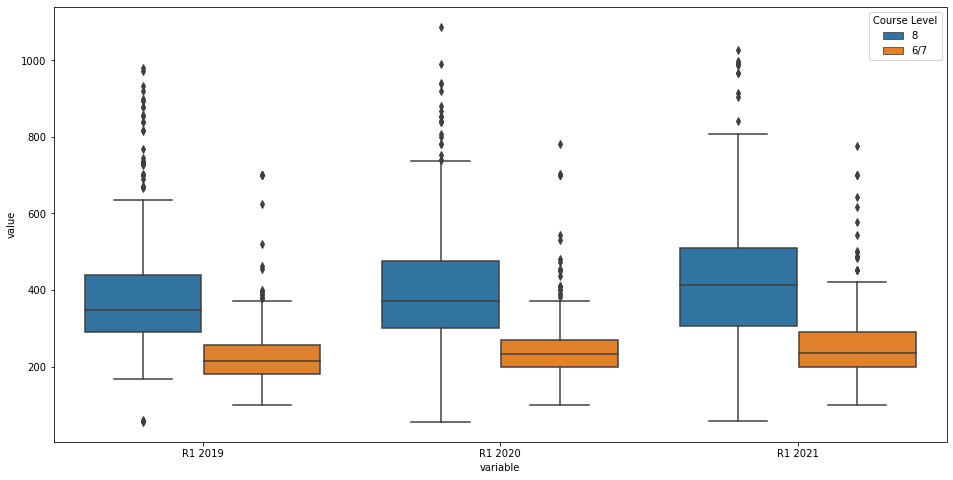

In [155]:
# https://stackoverflow.com/questions/49554139/boxplot-of-multiple-columns-of-a-pandas-dataframe-on-the-same-figure-seaborn
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.melt.html

plt.rcParams["figure.figsize"] = [16, 8]
sns.boxplot(x='variable', y='value', hue='Course Level', data=pd.melt(allcourses, id_vars=['Course Level'], value_vars = ['R1 2019', 'R1 2020', 'R1 2021']))
plt.show()

### 6.1 Which Course Categories and Institutions have the highest average CAO Points requirements?

In [129]:
# Pivot tables as per:
# https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html
pivot = pd.pivot_table(allcourses, values='R1 2021', columns=['CATEGORY'], index=['HEI'], margins=True, margins_name='Average',  aggfunc=np.mean)
# Sort by 'Average' column, highest on the top
pivot.sort_values(by='Average', inplace=True, ascending=False)
# Remove the 'Average' row
pivot.drop(index='Average', inplace=True)

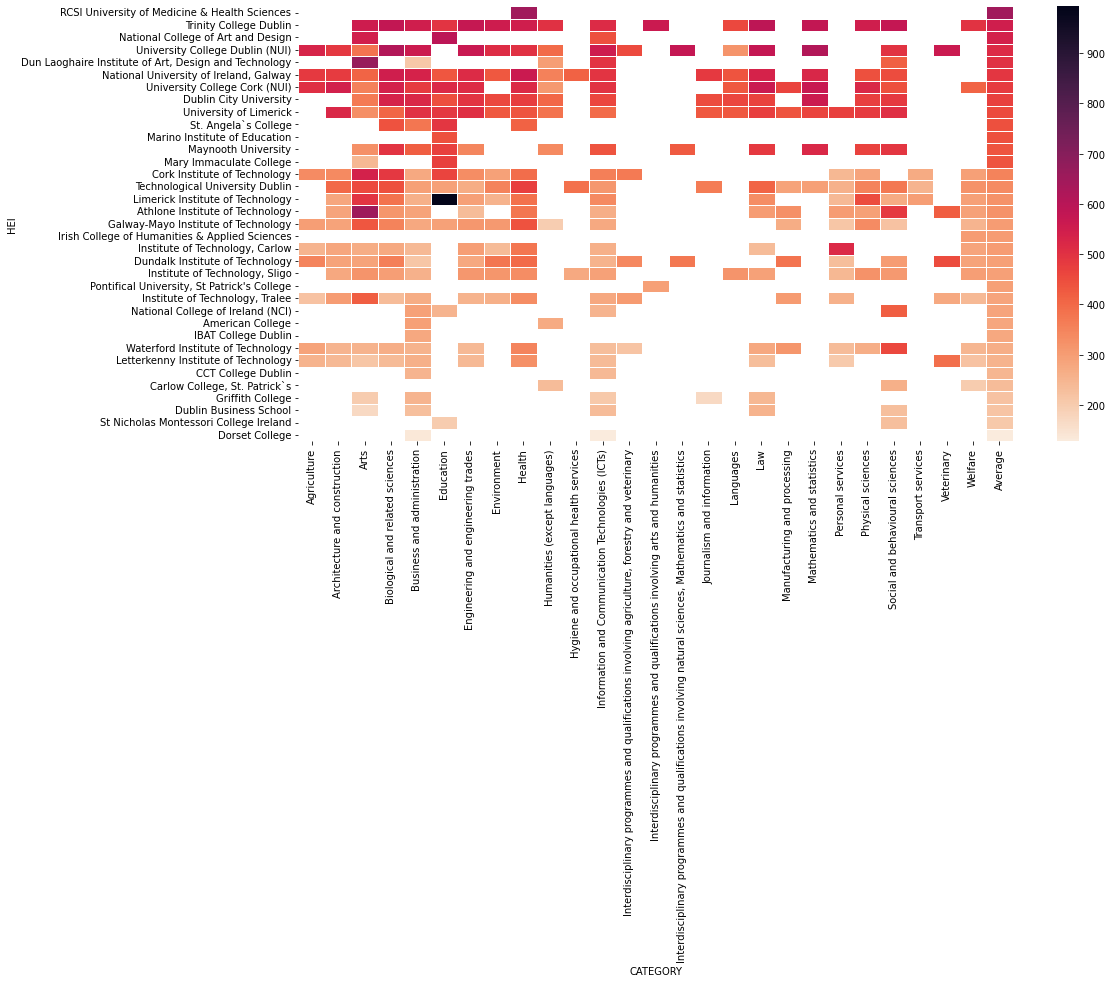

In [130]:
# Setting colour pallets in Seaborn as per:
# https://seaborn.pydata.org/tutorial/color_palettes.html
# and https://www.python-graph-gallery.com/92-control-color-in-seaborn-heatmaps
plt.rcParams["figure.figsize"] = [16, 8]

ax = sns.heatmap(pivot, linewidth=0.5,  cmap="rocket_r")
plt.show()

###### Check the Category and HEI with the largest Points requirements as per the Heatmap above

In [131]:
# Boolean indexing on multiple columns as per:
# https://stackoverflow.com/questions/17216153/python-pandas-boolean-indexing-on-multiple-columns/17216674
allcourses[(allcourses['CATEGORY']=='Education') & (allcourses['HEI']=='Limerick Institute of Technology')]

,COURSE TITLE,Course Level,CATEGORY,Code,HEI,R1 2019,R2 2019,R1 2020,R2 2020,R1 2021,R2 2021
COURSE CODE,,,,,,,,,,,
LC115,Art and Design Teacher Education (portfolio),8,Education,LC,Limerick Institute of Technology,NaN,NaN,942.0,NaN,993.0,NaN


#### Calculate the Year to Year change in the points requirements

In [132]:
# calculate the year to year diffrences in points requirements for all the courses
allcourses['R1 21_to_20'] = allcourses['R1 2021'] - allcourses['R1 2020']
allcourses['R1 21_to_19'] = allcourses['R1 2021'] - allcourses['R1 2019']
allcourses['R1 20_to_19'] = allcourses['R1 2020'] - allcourses['R1 2019']
allcourses.head()

,COURSE TITLE,Course Level,CATEGORY,Code,HEI,R1 2019,R2 2019,R1 2020,R2 2020,R1 2021,R2 2021,R1 21_to_20,R1 21_to_19,R1 20_to_19
COURSE CODE,,,,,,,,,,,,,,
AL801,Software Design with Virtual Reality and Gaming,8,Information and Communication Technologies (ICTs),AL,Athlone Institute of Technology,304.0,328.0,303.0,NaN,300.0,NaN,-3.0,-4.0,-1.0
AL802,Software Design with Cloud Computing,8,Information and Communication Technologies (ICTs),AL,Athlone Institute of Technology,301.0,306.0,332.0,NaN,313.0,NaN,-19.0,12.0,31.0
AL803,Software Design with Mobile Apps and Connected...,8,Information and Communication Technologies (ICTs),AL,Athlone Institute of Technology,309.0,337.0,337.0,NaN,350.0,NaN,13.0,41.0,28.0
AL805,Network Management and Cloud Infrastructure,8,Information and Communication Technologies (ICTs),AL,Athlone Institute of Technology,329.0,442.0,333.0,NaN,321.0,NaN,-12.0,-8.0,4.0
AL810,Quantity Surveying,8,Architecture and construction,AL,Athlone Institute of Technology,307.0,349.0,319.0,NaN,328.0,NaN,9.0,21.0,12.0


### 6.2 Which Course Category and HE Institutions experience the largest increase in Points requirements in 2021?

In [133]:
# Pivot tables as per:
# https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html
pivot = pd.pivot_table(allcourses, values='R1 21_to_20', columns=['CATEGORY'], index=['HEI'], margins=True, margins_name='Average change',  aggfunc=np.mean)
# Sort by 'Average' column, highest on the top
pivot.sort_values(by='Average change', inplace=True, ascending=False)
# Remove the 'Average' row
pivot.drop(index='Average change', inplace=True)

In [134]:
#Find the maximum absolute change in points
colour_limit = max( max(pivot.max()), np.abs( min(pivot.min())) )

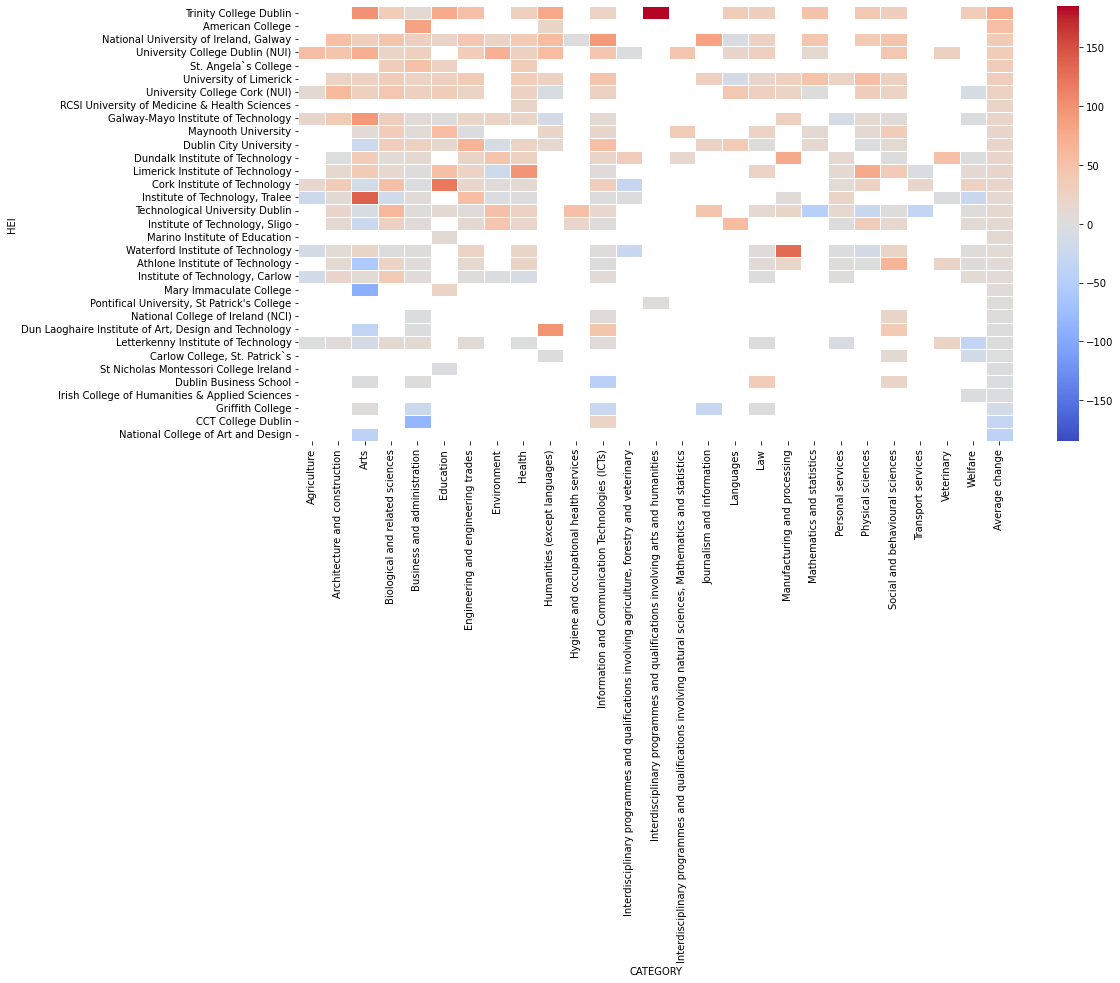

In [135]:
# Setting colour pallets in Seaborn as per:
# https://seaborn.pydata.org/tutorial/color_palettes.html
# and https://www.python-graph-gallery.com/92-control-color-in-seaborn-heatmaps

# Setting symetrical limits for colur mapping, to ensure that increse in points will be mapped to red and decrease of points will be mapped blue
ax = sns.heatmap(pivot, linewidth=0.5,  cmap="coolwarm", vmin=-colour_limit, vmax=colour_limit)
plt.rcParams["figure.figsize"] = [16, 8]
plt.show()

### 6.3 Which courses had the largest change in points requirements for Round 1 between 2019 to 2019 and 2020 to 2021?

In [136]:
# Find which course got the highest points increse in 2021
max_21_20 = allcourses[allcourses['R1 21_to_20'] == allcourses['R1 21_to_20'].max()].index[0]

In [137]:
# Find which course got the highest points increse since 2019
max_21_19 = allcourses[allcourses['R1 21_to_19'] == allcourses['R1 21_to_19'].max()].index[0]

In [138]:
# Find which course got the highest points decrease in 2021
min_21_20 = allcourses[allcourses['R1 21_to_20'] == allcourses['R1 21_to_20'].min()].index[0]

In [139]:
# Find which course got the highest points decrease since 2019
min_21_19 = allcourses[allcourses['R1 21_to_19'] == allcourses['R1 21_to_19'].min()].index[0]

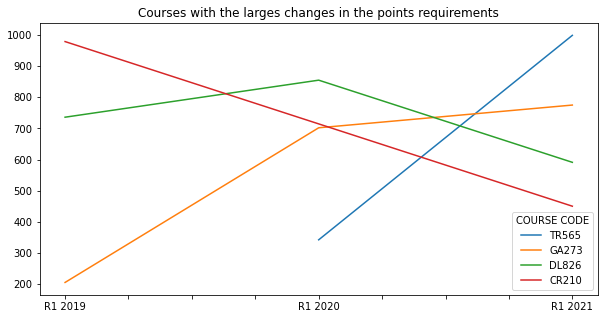

In [140]:
# Transpose a slice of allcourses DataFrame with only R1 points for each year
allcourses_t = allcourses[['R1 2019', 'R1 2020', 'R1 2021']].T

# Plot changes in the points requirements in the courses with the largest points requirements changes
# 'max_21_20' and others are variables that hold the course names with the largest points changes. Below I will use these variables
# to select only the columns that corresponds to these courses:
# Interpolating missing 2020 value for CR210 by interpolating the values in 2019 and 2021. As a result straight line will be draw for CR210 between 2019 and 2021 values
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html
allcourses_t[[max_21_20, max_21_19, min_21_20, min_21_19]].interpolate(method='linear', limit=2).plot(figsize=(10, 5), title='Courses with the larges changes in the points requirements')
plt.show()

In [141]:
# Show courses details for the courses above, values missing for TR565 in 2019 and CR210 in 2020
allcourses.loc[[max_21_20, max_21_19, min_21_20, min_21_19]]

,COURSE TITLE,Course Level,CATEGORY,Code,HEI,R1 2019,R2 2019,R1 2020,R2 2020,R1 2021,R2 2021,R1 21_to_20,R1 21_to_19,R1 20_to_19
COURSE CODE,,,,,,,,,,,,,,
TR565,"Middle Eastern,Jewish and Islamic Civilisation...",8,Arts,TR,Trinity College Dublin,NaN,NaN,342.0,NaN,999.0,949.0,657.0,NaN,NaN
GA273,Contemporary Art,6/7,Arts,GA,Galway-Mayo Institute of Technology,205.0,398.0,702.0,NaN,775.0,NaN,73.0,570.0,497.0
DL826,Visual Communication Design,8,Arts,DL,"Dun Laoghaire Institute of Art, Design and Tec...",736.0,989.0,855.0,NaN,591.0,NaN,-264.0,-145.0,119.0
CR210,"Contemporary Applied Art (Ceramics, Glass, Tex...",8,Arts,CR,Cork Institute of Technology,979.0,979.0,NaN,NaN,450.0,NaN,NaN,-529.0,NaN


### 6.4 What are the mean points requirements for each HEI?

In [142]:
# https://www.kite.com/python/answers/how-to-group-a-pandas-dataframe-by-a-column-and-compute-the-mean-of-each-group-in-python
mean_by_hei = allcourses.groupby('HEI').mean()
mean_by_hei.head()

,R1 2019,R2 2019,R1 2020,R2 2020,R1 2021,R2 2021,R1 21_to_20,R1 21_to_19,R1 20_to_19
HEI,,,,,,,,,
American College,243.000000,272.00000,230.500000,NaN,282.500000,282.000,52.000000,39.500000,-12.500000
Athlone Institute of Technology,307.075472,379.77193,313.471698,300.0,322.018519,423.400,6.760000,12.934783,6.020833
CCT College Dublin,191.000000,331.75000,246.750000,NaN,247.500000,247.500,-31.500000,7.000000,21.666667
"Carlow College, St. Patrick`s",187.000000,289.40000,235.400000,190.4,234.200000,180.400,-1.200000,55.750000,53.000000
Cork Institute of Technology,364.600000,463.80000,358.876712,490.2,353.864865,366.375,17.753623,9.436620,19.000000


In [143]:
# Create a new Dataframe by joining mean points requirements for HEI with HEI DF
hei_summary = hei.set_index('HEI').join(mean_by_hei[['R1 2019', 'R2 2019', 'R1 2020', 'R2 2020', 'R1 2021', 'R2 2021', 'R1 21_to_20', 'R1 21_to_19', 'R1 20_to_19']])

# Sort Institution by the largest increase in points requirements from 2019 to 2020
hei_summary.sort_values(by='R1 21_to_19', ascending=False, inplace=True)
hei_summary.head()

,R1 2019,R2 2019,R1 2020,R2 2020,R1 2021,R2 2021,R1 21_to_20,R1 21_to_19,R1 20_to_19
HEI,,,,,,,,,
Trinity College Dublin,478.800000,512.750000,479.617188,505.600000,549.360294,566.974359,73.364407,64.018519,29.400000
St. Angela`s College,387.000000,419.142857,411.714286,383.400000,444.857143,428.285714,33.142857,57.857143,24.714286
University College Dublin (NUI),445.410256,475.589744,478.358974,485.136364,513.666667,522.636364,34.600000,56.200000,23.789474
"Carlow College, St. Patrick`s",187.000000,289.400000,235.400000,190.400000,234.200000,180.400000,-1.200000,55.750000,53.000000
University of Limerick,401.595238,450.952381,424.181818,NaN,454.638298,468.000000,31.409091,52.571429,20.904762


#### Which Higher Education Institute increased their Points requirements the MOST in 2021 comparing to 2019?

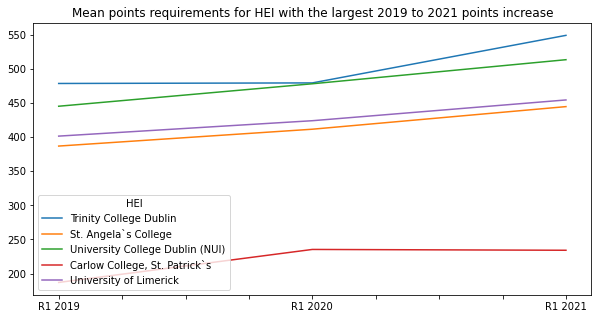

In [144]:
# Plot mean points requirements Year by Year for all HEI
fig = hei_summary[['R1 2019', 'R1 2020', 'R1 2021']].T.iloc[:,0:5].plot(figsize=(10, 5), legend=True, title='Mean points requirements for HEI with the largest 2019 to 2021 points increase')
fig.figure.savefig('out/hei_year_by_year.png')

#### Which Higher Education Institute increased their Points requirements the LEAST in 2021 comparing to 2019?

In [145]:
# Sort Institution by the smallest increase in points requirements from 2019 to 2020
hei_summary.sort_values(by='R1 21_to_19', ascending=True, inplace=True)

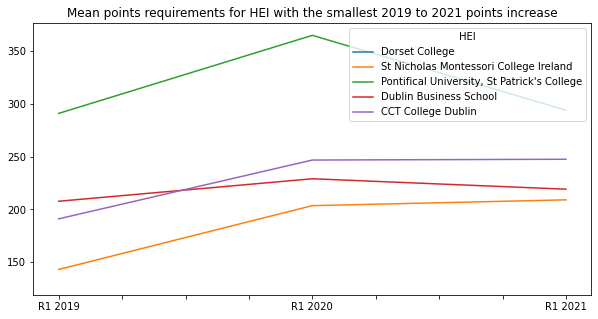

In [146]:
# Plot mean points requirements Year by Year for all HEI
fig = hei_summary[['R1 2019', 'R1 2020', 'R1 2021']].T.iloc[:,0:5].plot(figsize=(10, 5), legend=True, title='Mean points requirements for HEI with the smallest 2019 to 2021 points increase')
fig.figure.savefig('out/hei_year_by_year_.png')

### 6.5 What are the mean Points requirements by Course Category?

In [147]:
# Cerate a categories DataFrame: Courses categories with mean points requirements 

categories = allcourses[['CATEGORY','R1 2019', 'R1 2020', 'R1 2021']].groupby('CATEGORY').mean()
categories['R1 21_to_20'] = categories['R1 2021'] - categories['R1 2020']
categories['R1 21_to_19'] = categories['R1 2021'] - categories['R1 2019']
categories['R1 20_to_19'] = categories['R1 2020'] - categories['R1 2019']
categories.sort_values(by='R1 21_to_19', ascending=False)

,R1 2019,R1 2020,R1 2021,R1 21_to_20,R1 21_to_19,R1 20_to_19
CATEGORY,,,,,,
Interdisciplinary programmes and qualifications involving arts and humanities,291.000000,385.200000,509.200000,124.000000,218.200000,94.200000
Biological and related sciences,345.173077,371.014925,405.720588,34.705663,60.547511,25.841848
Social and behavioural sciences,375.391304,387.235294,433.800000,46.564706,58.408696,11.843990
Arts,398.169492,434.198953,453.457286,19.258334,55.287795,36.029461
Health,397.176471,429.507937,451.269841,21.761905,54.093371,32.331466
Environment,294.071429,307.714286,344.160000,36.445714,50.088571,13.642857
"Interdisciplinary programmes and qualifications involving natural sciences, Mathematics and statistics",403.750000,418.250000,450.750000,32.500000,47.000000,14.500000
Humanities (except languages),321.500000,336.961538,368.260870,31.299331,46.760870,15.461538
Architecture and construction,269.848485,296.666667,315.584416,18.917749,45.735931,26.818182


#### Which Course Categories increased their Points requirements the MOST in 2021 comparing to 2019?

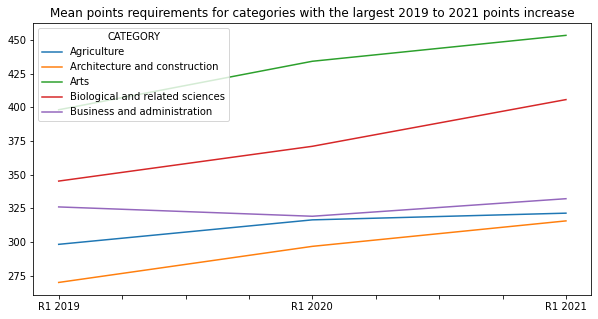

In [148]:
# Plot mean points requirements Year by Year for all HEI
fig = categories[['R1 2019', 'R1 2020', 'R1 2021']].T.iloc[:,0:5].plot(figsize=(10, 5), legend=True, title='Mean points requirements for categories with the largest 2019 to 2021 points increase')
fig.figure.savefig('out/cat_year_by_year.png')

#### Which Course Categories increased their Points requirements the LEAST in 2021 comparing to 2019?

In [149]:
# Sort categories df by the total change in points requirements from 2019 to 2021
categories.sort_values(by='R1 21_to_19', ascending=True, inplace=True)

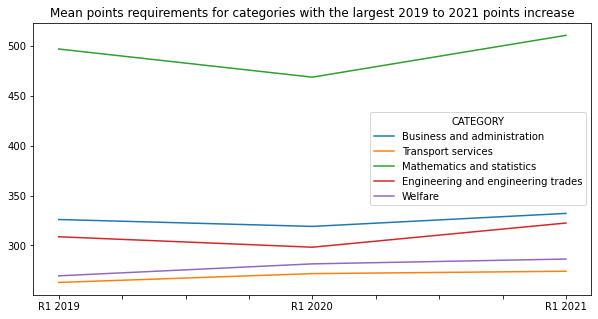

In [150]:
# Plot mean points requirements Year by Year for all HEI
fig = categories[['R1 2019', 'R1 2020', 'R1 2021']].T.iloc[:,0:5].plot(figsize=(10, 5), legend=True, title='Mean points requirements for categories with the largest 2019 to 2021 points increase')
fig.figure.savefig('out/cat_year_by_year_ascend.png')

#### Plots

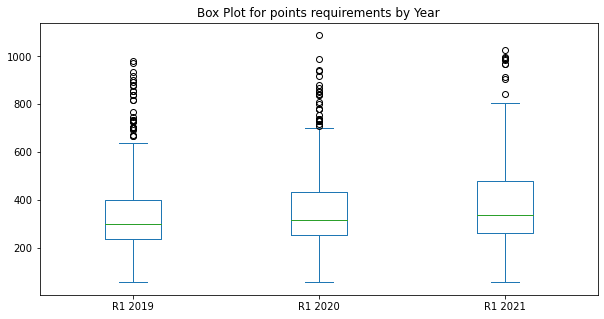

In [151]:
# Draw a boxlot of data for each year groupped by HEI
hist = allcourses[['R1 2019', 'R1 2020', 'R1 2021', 'HEI']].plot.box(figsize=(10, 5), title='Box Plot for points requirements by Year')

# as per https://stackoverflow.com/questions/19555525/saving-plots-axessubplot-generated-from-python-pandas-with-matplotlibs-savefi
hist.figure.savefig('out/box_all_by_year.png')

## References

# End
